In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_log_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit

In [3]:
# Training data
df_part1 = pd.read_csv("data/train1.csv", index_col="id")
df_part2 = pd.read_csv("data/train2.csv", index_col="id")

# Concatenate dataframes
train_df = pd.concat([df_part1, df_part2])

# Remaining data
store_df = pd.read_csv("data/stores.csv")
oil_df = pd.read_csv("data/oil.csv")
holidays_df = pd.read_csv("data/holidays_events.csv")

## Exploration


### Training data


In [4]:
print(train_df.shape)
train_df.head()

(3000888, 5)


,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [5]:
# Convert the date column type to datetime
train_df["date"] = pd.to_datetime(train_df["date"])

In [6]:
train_df.dtypes

date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

The datatypes seem reasonable for the data they contain.


In [7]:
print(train_df.family.unique())
train_df.family.unique().shape

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


(33,)

There are 33 product families.


In [8]:
print(train_df.store_nbr.unique())
train_df.store_nbr.unique().shape

[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]


(54,)

There are 54 stores.


In [9]:
train_df.isnull().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

The training data doesn't contain any missing values.


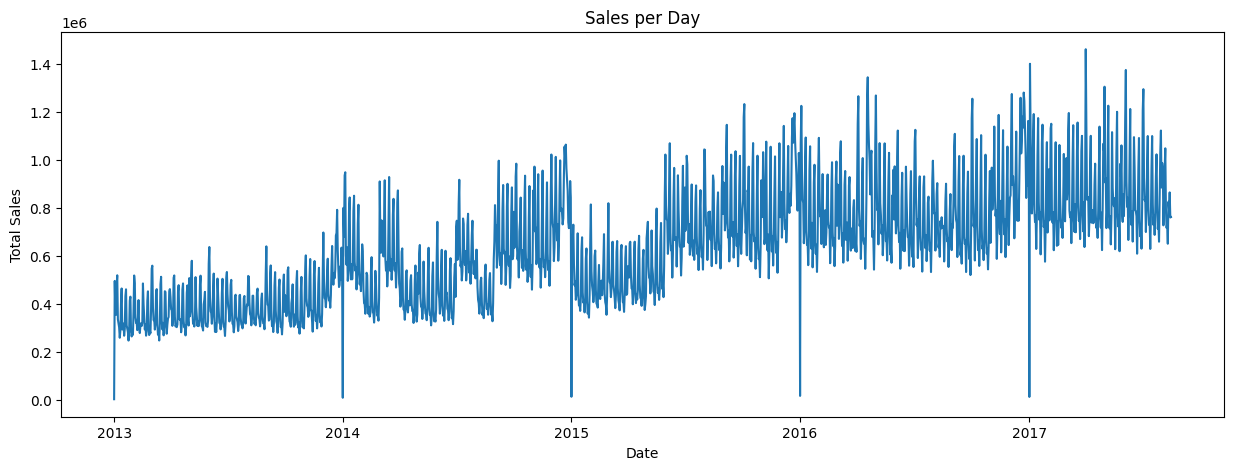

In [10]:
total_sales_per_day = train_df.groupby("date")["sales"].sum().reset_index()
plt.figure(figsize=(15, 5))
plt.plot(total_sales_per_day["date"], total_sales_per_day["sales"])
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Sales per Day")
plt.show()

The general trend is that the data increases with each year. For each year, the sales increase toward the end of the year, then dropping in the beggining of the next year, with a huge spike on the first day of each year.


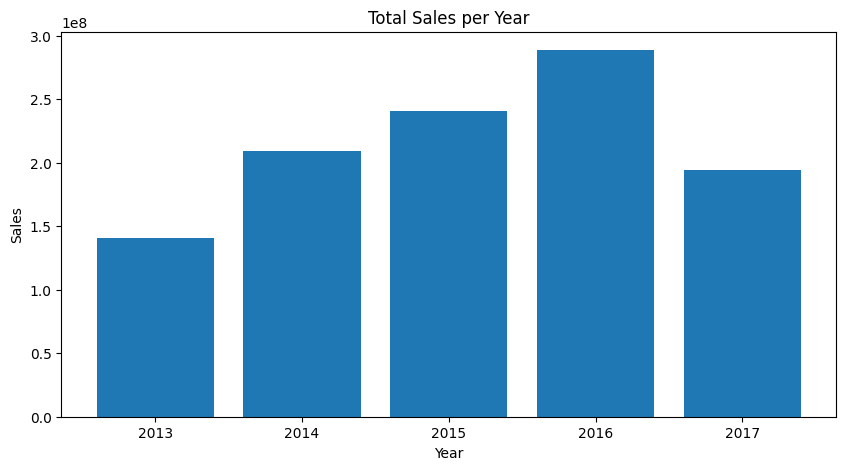

In [11]:
total_sales_per_year = train_df.groupby(train_df["date"].dt.year)["sales"].sum().reset_index()
plt.figure(figsize=(10, 5))
plt.bar(total_sales_per_year["date"], total_sales_per_year["sales"])
plt.xlabel("Year")
plt.ylabel("Sales")
plt.title("Total Sales per Year")
plt.show()

Here we also see that the sales generally increase each year. 2017 is lower since the dataset doesn't contain data for the entire year.


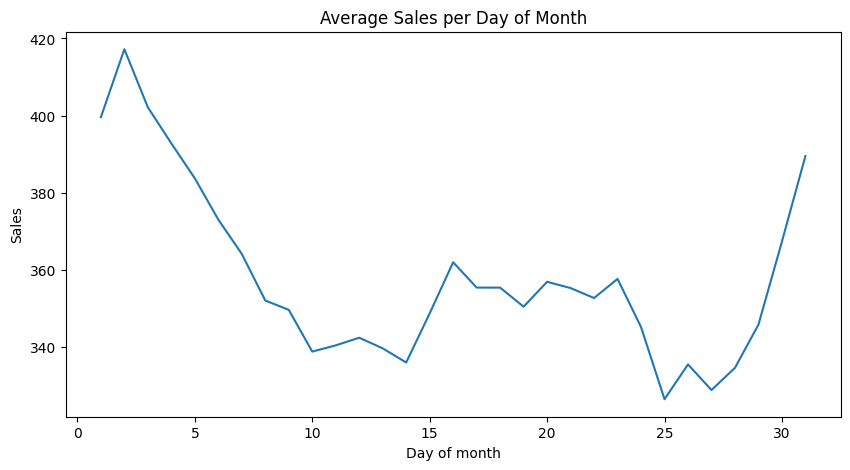

In [12]:
average_sales_per_day_of_month = train_df.groupby(train_df["date"].dt.day)["sales"].mean().reset_index()
plt.figure(figsize=(10, 5))
plt.plot(average_sales_per_day_of_month["date"], average_sales_per_day_of_month["sales"])
plt.xlabel("Day of month")
plt.ylabel("Sales")
plt.title("Average Sales per Day of Month")
plt.show()

We see a peak in the middle of the month and the end of the month due to wages being paid on the 15th and on the last day of the month.


### Store data


In [13]:
print(store_df.shape)
store_df.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [14]:
print(store_df.city.unique())
store_df.city.unique().shape

['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']


(22,)

There are 22 different cities with stores in them.


In [15]:
print(store_df.state.unique())
store_df.state.unique().shape

['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']


(16,)

The 22 stores are located in 16 different states.


In [16]:
print(store_df.type.unique())
store_df.type.unique().shape

['D' 'B' 'C' 'E' 'A']


(5,)

There are 5 types of stores.


In [17]:
print(store_df.cluster.unique())
store_df.cluster.unique().shape

[13  8  9  4  6 15  7  3 12 16  1 10  2  5 11 14 17]


(17,)

There are 17 clusters of similar stores.


In [18]:
store_df.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

The dataset doesn't contain any missing values.


### Oil Data

Inspect data

In [19]:
# Inspect the first few rows
print(oil_df.head())

# Check the column names and data types
print(oil_df.info())

# Summarize numerical data
print(oil_df.describe())

         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None
        dcoilwtico
count  1175.000000
mean     67.714366
std      25.630476
min      26.190000
25%      46.405000
50%      53.190000
75%      95.660000
max     110.620000


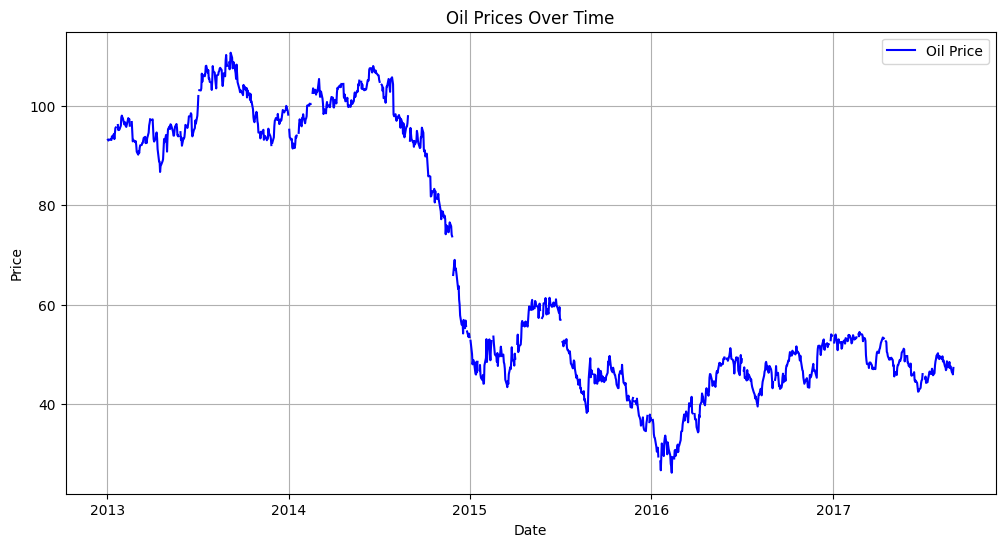

In [20]:
#Plot data

# Ensure the date column is in datetime format
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Sort by date to ensure correct ordering
oil_df = oil_df.sort_values('date')

# Plot the oil price over time
plt.figure(figsize=(12, 6))
plt.plot(oil_df['date'], oil_df['dcoilwtico'], label='Oil Price', color='blue')
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Check the column names and data types
print(oil_df.info())

missing_dates = oil_df[oil_df['date'].isna() & oil_df['dcoilwtico'].notna()]

# Display rows with missing dates but valid prices
print(missing_dates)

# Count the number of such rows
print(f"Number of rows with missing dates but valid prices: {len(missing_dates)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB
None
Empty DataFrame
Columns: [date, dcoilwtico]
Index: []
Number of rows with missing dates but valid prices: 0


### Merge,Clean data and fix missing values with interpolation

In [22]:
# Convert columns to datetime format
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Merge train_df with oil_df on 'date', keeping all rows from train_df
train_df = pd.merge(train_df, oil_df[['date', 'dcoilwtico']], on='date', how='left')

# Interpolate missing values (linear interpolation)
train_df['dcoilwtico'] = train_df['dcoilwtico'].interpolate(method='linear')

In [23]:
# Check the first few rows after interpolation
print(train_df.head())

specific_date_data = train_df[train_df['date'] == '2013-01-03']

# Print rows for this specific date
print(specific_date_data)

        date  store_nbr      family  sales  onpromotion  dcoilwtico
0 2013-01-01          1  AUTOMOTIVE    0.0            0         NaN
1 2013-01-01          1   BABY CARE    0.0            0         NaN
2 2013-01-01          1      BEAUTY    0.0            0         NaN
3 2013-01-01          1   BEVERAGES    0.0            0         NaN
4 2013-01-01          1       BOOKS    0.0            0         NaN
           date  store_nbr                      family    sales  onpromotion  \
3564 2013-01-03          1                  AUTOMOTIVE    3.000            0   
3565 2013-01-03          1                   BABY CARE    0.000            0   
3566 2013-01-03          1                      BEAUTY    0.000            0   
3567 2013-01-03          1                   BEVERAGES  919.000            0   
3568 2013-01-03          1                       BOOKS    0.000            0   
...         ...        ...                         ...      ...          ...   
5341 2013-01-03          9      

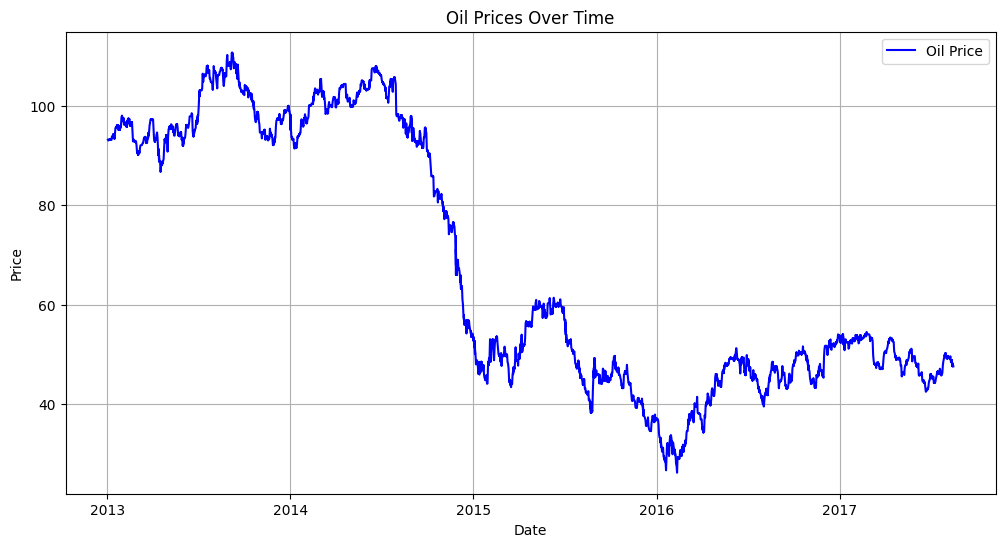

In [24]:
#Plot data

# Ensure the date column is in datetime format
train_df['date'] = pd.to_datetime(train_df['date'])

# Sort by date to ensure correct ordering
train_df = train_df.sort_values('date')

# Plot the oil price and sales data over time
plt.figure(figsize=(12, 6))

# Plot oil price
plt.plot(train_df['date'], train_df['dcoilwtico'], label='Oil Price', color='blue')

# Title and labels
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')

# Add a legend to the plot
plt.legend()

# Display gridlines
plt.grid(True)

# Show the plot
plt.show()


In [25]:
# Check unique dates in both train_df and oil_df
print("Train dates:", train_df['date'].min(), train_df['date'].max())
print("Oil dates:", oil_df['date'].min(), oil_df['date'].max())

# Check for any dates in train_df that are not in oil_df
missing_dates = train_df[~train_df['date'].isin(oil_df['date'])]
print("Missing Dates:", missing_dates['date'].unique())

Train dates: 2013-01-01 00:00:00 2017-08-15 00:00:00
Oil dates: 2013-01-01 00:00:00 2017-08-31 00:00:00
Missing Dates: <DatetimeArray>
['2013-01-05 00:00:00', '2013-01-06 00:00:00', '2013-01-12 00:00:00',
 '2013-01-13 00:00:00', '2013-01-19 00:00:00', '2013-01-20 00:00:00',
 '2013-01-26 00:00:00', '2013-01-27 00:00:00', '2013-02-02 00:00:00',
 '2013-02-03 00:00:00',
 ...
 '2017-07-15 00:00:00', '2017-07-16 00:00:00', '2017-07-22 00:00:00',
 '2017-07-23 00:00:00', '2017-07-29 00:00:00', '2017-07-30 00:00:00',
 '2017-08-05 00:00:00', '2017-08-06 00:00:00', '2017-08-12 00:00:00',
 '2017-08-13 00:00:00']
Length: 481, dtype: datetime64[ns]


In [26]:
print(train_df[['dcoilwtico', 'sales']].corr())

            dcoilwtico     sales
dcoilwtico    1.000000 -0.074822
sales        -0.074822  1.000000


### Exploring correlation

In [27]:
# Aggregate sales data by date
daily_sales = train_df.groupby('date')['sales'].sum().reset_index()

# Check the first few rows
print(daily_sales.head())

        date          sales
0 2013-01-01    2511.618999
1 2013-01-02  496092.417944
2 2013-01-03  361461.231124
3 2013-01-04  354459.677093
4 2013-01-05  477350.121229


In [28]:
# Merge daily sales with oil prices
daily_data = pd.merge(daily_sales, oil_df, on='date', how='inner')

# Fill missing dcoilwtico using linear interpolation
daily_data['dcoilwtico'] = daily_data['dcoilwtico'].interpolate(method='linear')

# Check the merged data
print(daily_data.head())


        date          sales  dcoilwtico
0 2013-01-01    2511.618999         NaN
1 2013-01-02  496092.417944       93.14
2 2013-01-03  361461.231124       92.97
3 2013-01-04  354459.677093       93.12
4 2013-01-07  336122.801066       93.20


In [29]:
# Compute correlation
correlation = daily_data['sales'].corr(daily_data['dcoilwtico'])
print(f"Correlation between daily sales and oil prices: {correlation:.4f}")

Correlation between daily sales and oil prices: -0.6905


In [30]:
# Calculate the percentage change for oil prices and sales
daily_data['oil_pct_change'] = daily_data['dcoilwtico'].pct_change() * 100  # Oil price percentage change
daily_data['sales_pct_change'] = daily_data['sales'].pct_change() * 100      # Sales percentage change

# Drop rows with NaN values (due to the pct_change calculation, the first row will have NaN)
daily_data = daily_data.dropna(subset=['oil_pct_change', 'sales_pct_change'])

# Calculate the correlation between the percentage changes
correlation_pct_change = daily_data[['sales_pct_change', 'oil_pct_change']].corr().iloc[0, 1]

print(f"Correlation between sales and oil price percentage changes: {correlation_pct_change:.4f}")


Correlation between sales and oil price percentage changes: -0.0215


### Lag and rolling avrages

C:\Users\pette\AppData\Local\Temp\ipykernel_1680\3354114318.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  daily_data[f'oil_lag_{lag}'] = daily_data['dcoilwtico'].shift(lag)
C:\Users\pette\AppData\Local\Temp\ipykernel_1680\3354114318.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  daily_data[f'oil_lag_{lag}'] = daily_data['dcoilwtico'].shift(lag)
C:\Users\pette\AppData\Local\Temp\ipykernel_1680\3354114318.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

Best lag: 118 days
Correlation with best lag: 0.0440
Best rolling window: 9 days
Correlation with best rolling window: 0.0122


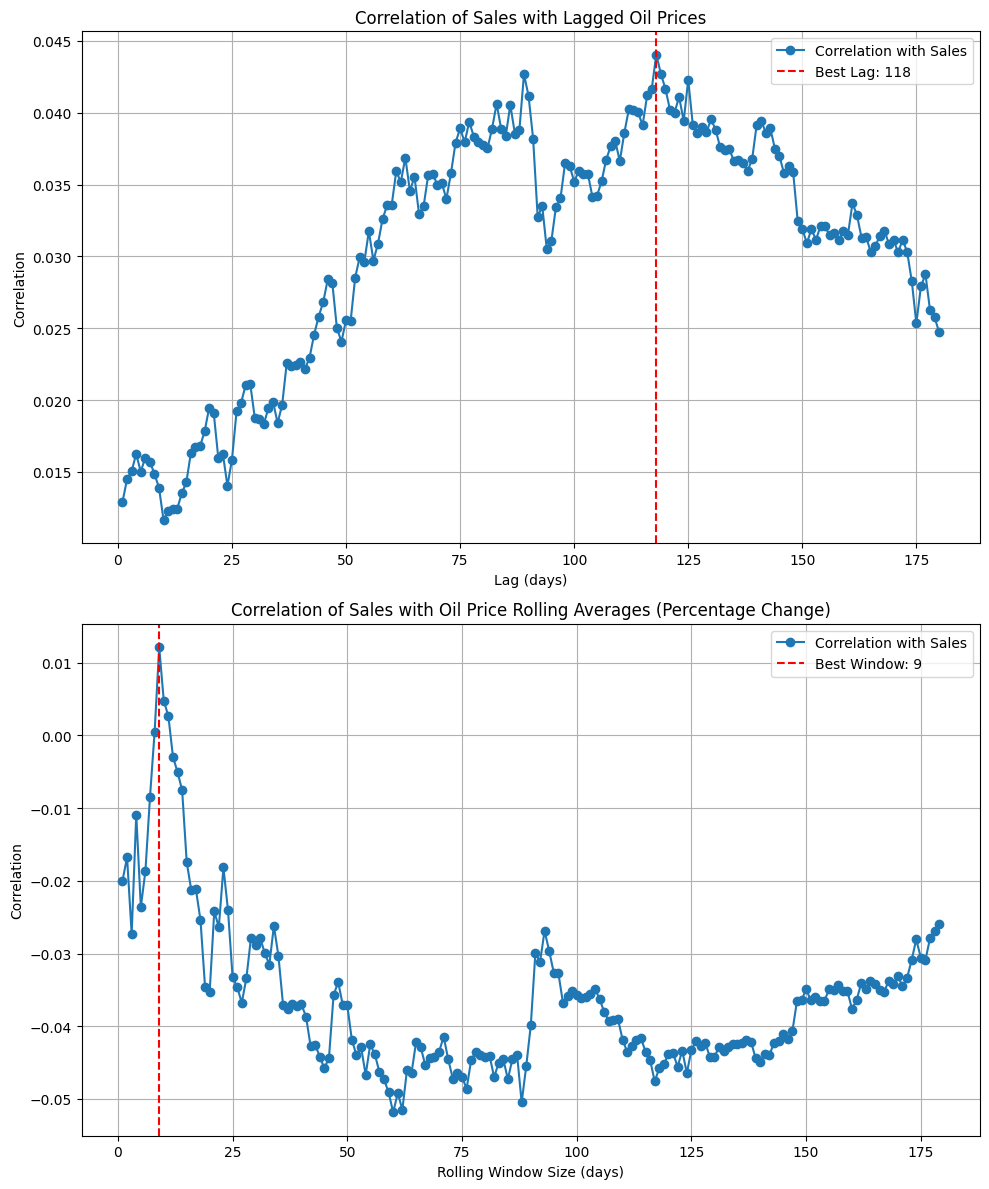

In [31]:
max_lag = 180  # Or adjust to your preferred lag length

# Create lagged columns for oil prices in the daily_data DataFrame
for lag in range(1, max_lag + 1):
    daily_data[f'oil_lag_{lag}'] = daily_data['dcoilwtico'].shift(lag)

# Create rolling averages for oil percentage change
rolling_averages = {
    f'oil_rolling_avg_{window}': daily_data['oil_pct_change'].rolling(window=window).mean().shift(1)
    for window in range(1, 180)  # Adjust window range as needed
}

# Create a DataFrame with rolling averages and sales percentage change
rolling_avg_df = pd.DataFrame(rolling_averages)
rolling_avg_df['sales_pct_change'] = daily_data['sales_pct_change'].values

# Merge the lag columns from daily_data into rolling_avg_df (valid_data)
valid_data = pd.concat([rolling_avg_df, daily_data[[f'oil_lag_{lag}' for lag in range(1, max_lag + 1)]]], axis=1)

# Drop rows with NaN values in the relevant columns (both rolling averages and lag columns)
valid_data_clean = valid_data.dropna(subset=[f'oil_lag_{lag}' for lag in range(1, max_lag + 1)] +
                                      [f'oil_rolling_avg_{window}' for window in range(1, 180)] +
                                      ['sales_pct_change'])

# Correlation analysis for lagged oil prices
lag_correlations = []
for lag in range(1, max_lag + 1):
    lagged_col = f'oil_lag_{lag}'
    corr = valid_data_clean['sales_pct_change'].corr(valid_data_clean[lagged_col])
    lag_correlations.append(corr)

# Correlation analysis for rolling averages of oil percentage change
rolling_correlations = []
for window in range(1, 180):
    rolling_col = f'oil_rolling_avg_{window}'
    corr = valid_data_clean['sales_pct_change'].corr(valid_data_clean[rolling_col])
    rolling_correlations.append(corr)

# Find the best lag and best rolling window based on correlation
best_lag = np.argmax(np.abs(lag_correlations)) + 1
best_lag_corr = lag_correlations[best_lag - 1]

positive_rolling_correlations = [corr if corr > 0 else -np.inf for corr in rolling_correlations]
best_rolling_window = np.argmax(positive_rolling_correlations) + 1
best_rolling_corr = positive_rolling_correlations[best_rolling_window - 1]

# Output the results
print(f"Best lag: {best_lag} days")
print(f"Correlation with best lag: {best_lag_corr:.4f}")
print(f"Best rolling window: {best_rolling_window} days")
print(f"Correlation with best rolling window: {best_rolling_corr:.4f}")

# Plot the correlation results
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot correlation for lagged oil prices
axes[0].plot(range(1, max_lag + 1), lag_correlations, marker='o', label='Correlation with Sales')
axes[0].axvline(best_lag, color='red', linestyle='--', label=f'Best Lag: {best_lag}')
axes[0].set_title('Correlation of Sales with Lagged Oil Prices')
axes[0].set_xlabel('Lag (days)')
axes[0].set_ylabel('Correlation')
axes[0].legend()
axes[0].grid(True)

# Plot correlation for rolling averages of oil percentage changes
axes[1].plot(range(1, 180), rolling_correlations, marker='o', label='Correlation with Sales')
axes[1].axvline(best_rolling_window, color='red', linestyle='--', label=f'Best Window: {best_rolling_window}')
axes[1].set_title('Correlation of Sales with Oil Price Rolling Averages (Percentage Change)')
axes[1].set_xlabel('Rolling Window Size (days)')
axes[1].set_ylabel('Correlation')
axes[1].legend()
axes[1].grid(True)

# Show both plots
plt.tight_layout()
plt.show()


rolling doesn't seem to work well but Lag seems to be indicating price changes which we can used to predict cost increases and therefore less sales


## Pre-processing


### Add features


In [32]:
holidays_df.tail()

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [33]:
train_df.tail

<bound method NDFrame.tail of               date  store_nbr         family    sales  onpromotion  dcoilwtico
0       2013-01-01          1     AUTOMOTIVE    0.000            0         NaN
1194    2013-01-01         42    CELEBRATION    0.000            0         NaN
1193    2013-01-01         42   BREAD/BAKERY    0.000            0         NaN
1192    2013-01-01         42          BOOKS    0.000            0         NaN
1191    2013-01-01         42      BEVERAGES    0.000            0         NaN
...            ...        ...            ...      ...          ...         ...
2999693 2017-08-15         25   PET SUPPLIES    3.000            0       47.57
2999692 2017-08-15         25  PERSONAL CARE   93.000            8       47.57
2999691 2017-08-15         25          MEATS  180.107            0       47.57
2999702 2017-08-15         26         BEAUTY    0.000            0       47.57
3000887 2017-08-15          9        SEAFOOD   16.000            0       47.57

[3000888 rows x 6 col

In [34]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Convert the date column type to datetime
    holidays_df["date"] = pd.to_datetime(holidays_df["date"])
    df["date"] = pd.to_datetime(df["date"])

    #holiday_features
    holiday_features = holidays_df[["date", "type", "locale", "locale_name", "description", "transferred"]]

    # Merge with store data
    df = df.merge(store_df, on="store_nbr", how="left")
    df = df.merge(holiday_features, on="date", how="left")

    # Information
    df["dayofweek"] = df["date"].dt.dayofweek
    df["quarter"] = df["date"].dt.quarter
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["dayofyear"] = df["date"].dt.dayofyear
    df["dayofmonth"] = df["date"].dt.day
    df["weekofyear"] = df["date"].dt.isocalendar().week

    # Holiday features
    df["is_holiday"] = df["type"].notna().astype(int)
    df["is_transferred_holiday"] = df["transferred"].fillna(False).astype(int)

    # Lag features
    # df["month_lag"] = df.groupby(["family", "store_nbr"])["sales"].shift(28)
    # df["two_month_lag"] = df.groupby(["family", "store_nbr"])["sales"].shift(56)
    # df["year_lag"] = df.groupby(["family", "store_nbr"])["sales"].shift(364)
    # df["two_year_lag"] = df.groupby(["family", "store_nbr"])["sales"].shift(728)

    # Boolean features
    # df["is_month_midpoint"] = df["date"].dt.day == 15
    # df["is_month_end"] = df["date"].dt.is_month_end

    # Remove now unnecessary features
    df = df.drop("date", axis=1)
    return df

### Create dataframes


In [35]:
# start_idx = train_df.loc[train_df["date"] == "2015-07-01"].index[0]
start_idx = 0
split_idx = train_df.loc[train_df["date"] == "2017-08-01"].index[0]

X_train = create_features(train_df)

y_train = X_train["sales"]
X_train = X_train.drop("sales", axis=1)

X_test = X_train[split_idx:]
y_test = y_train[split_idx:]

X_train = X_train[start_idx:split_idx]
y_train = y_train[start_idx:split_idx]

X_train.tail()

KeyError: 'type'

### Create pipeline


In [208]:
CATEGORICAL_FEATURES = ["family", "city", "state", "type"]
CONTINOUS_FEATURES = []

# Create a pipeline for categorical features
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[("cat", cat_pipeline, CATEGORICAL_FEATURES)], remainder="passthrough", force_int_remainder_cols=False
)

# Create the model
model = xgb.XGBRegressor(objective="reg:tweedie", random_state=0)

# Create the final pipeline
pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])

## Model training


RMSLE for fold 0: 0.6189
RMSLE for fold 1: 0.5157
RMSLE for fold 2: 0.6388
RMSLE for fold 3: 2.1993
RMSLE for fold 4: 1.0402
Average RMSLE: 1.0026


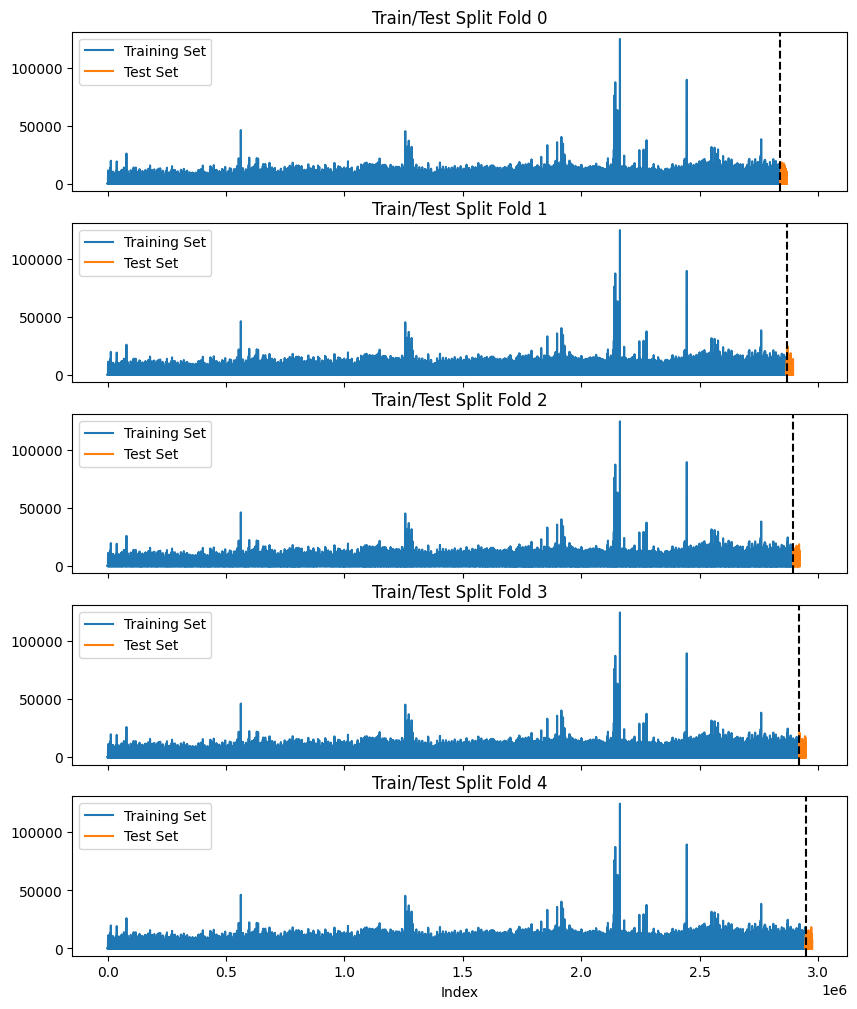

In [104]:
# Test size is 15 days
tss = TimeSeriesSplit(n_splits=5, test_size=33 * 54 * 15)
scores = []
fig, axes = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

for fold, (train_index, test_index) in enumerate(tss.split(X_train)):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    axes[fold].plot(y_train_cv, label="Training Set")
    axes[fold].plot(y_test_cv, label="Test Set")
    axes[fold].axvline(y_test_cv.index.min(), color="black", ls="--")
    axes[fold].legend()
    axes[fold].set_title(f"Train/Test Split Fold {fold}")

    pipeline.fit(X_train_cv, y_train_cv)
    y_pred = pipeline.predict(X_test_cv)

    score = root_mean_squared_log_error(y_test_cv, y_pred)
    scores.append(score)
    print(f"RMSLE for fold {fold}: {score:.4f}")

average_score = np.mean(scores)
print(f"Average RMSLE: {average_score:.4f}")

plt.xlabel("Index")
plt.show()

0.5181

with oil Average RMSLE: 0.7394

In [41]:
# Train full model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['family', 'city', 'state',
                                                   'type'])])),
                ('model',
                 XGBRegressor(base_score=N...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, objective='reg:tweedie', ...))])

### Validation


#### Baseline


Evaluating an average forecast model to see how much the final model improves on the base score.


In [42]:
full_data = X_train.copy()
full_data["sales"] = y_train
average_sales = full_data.groupby(["store_nbr", "family"])["sales"].mean().reset_index()
baseline_pred = pd.merge(X_test, average_sales, on=["store_nbr", "family"], how="left")["sales"]
print(f"RMSLE: {root_mean_squared_log_error(y_test, baseline_pred):.4f}")

RMSLE: 0.6957


0.6957


#### Final model


In [ ]:
y_pred = pipeline.predict(X_test)
print(f"RMSLE: {root_mean_squared_log_error(y_test, y_pred):.4f}")

RMSLE: 0.5898


0.4992
